# 9 GLMのベイズモデル化と事後分布の推定

In [19]:
using CSV
using DataFrames
using GLM
using LaTeXStrings
using LinearAlgebra
using Mamba
using Plots

In [2]:
df = CSV.read("data/section9.csv");
disallowmissing!(df)

,x,y
,Float64,Int64
1,3.0,5
2,3.21053,3
3,3.42105,6
4,3.63158,7
5,3.84211,7
6,4.05263,5
7,4.26316,9
8,4.47368,9
9,4.68421,7


In [3]:
df

,x,y
,Float64,Int64
1,3.0,5
2,3.21053,3
3,3.42105,6
4,3.63158,7
5,3.84211,7
6,4.05263,5
7,4.26316,9
8,4.47368,9
9,4.68421,7


## 9.1 例題 : 種子数のポアソン回帰 (個体差なし)

In [4]:
glm_model = glm(@formula(y ~ x), df, Poisson())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x

Coefficients:
              Estimate Std.Error z value Pr(>|z|)
(Intercept)    1.56606  0.359949 4.35077    <1e-4
x            0.0833412 0.0683847 1.21871   0.2230


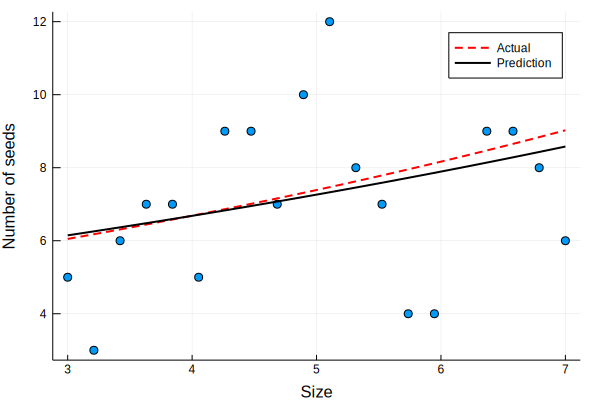

In [5]:
scatter(df.x, df.y, label = "", xlabel = "Size", ylabel = "Number of seeds")
xs = 3:0.1:7
xx = DataFrame(x = xs)
plot!(xs, exp.(1.5 .+ 0.1 .* xs), label = "Actual", linewidth = 2, 
    linestyle = :dash, linecolor = :red)
plot!(xs, predict(glm_model, xx), label = "Prediction", linewidth = 2, 
    linecolor = :black)

## 9.4 ベイズ統計モデルの事後分布の推定
### 9.4.1 ベイズ統計モデルのコーディング
\begin{align}
                y_i & \sim \text{Poisson}(\lambda_i)\\
    \log(\lambda_i) & =    \beta_1 + \beta_2 \cdot x_i\\
            \beta_1 & \sim \text{Normal}(0, 100^2)\\
            \beta_2 & \sim \text{Normal}(0, 100^2)
\end{align}
Mamba.jl ( https://mambajl.readthedocs.io/ )を使う
### モデルの作成

In [6]:
model = Model(
    y = Stochastic(1,
        (beta1, beta2, x, N) ->
        UnivariateDistribution[
            (lambda = exp(beta1 + beta2 * x[i]);
            Poisson(lambda)) for i in 1:N
        ],
        false),
    beta1 = Stochastic(
        () -> Normal(0.0, 100^2)),
    beta2 = Stochastic(
        () -> Normal(0.0, 100^2)),
    )

Object of type "Model"
-------------------------------------------------------------------------------
beta2:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
beta1:
A monitored node of type "ScalarStochastic"
NaN


### データの設定

In [7]:
data = Dict{Symbol, Any}(
  :x => df.x,
  :y => df.y
)
data[:N] = length(data[:x])
data

Dict{Symbol,Any} with 3 entries:
  :N => 20
  :y => [5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6]
  :x => [3.0, 3.21053, 3.42105, 3.63158, 3.84211, 4.05263, 4.26316, 4.47368, 4.…

### 初期値の設定

In [8]:
inits = [
    Dict{Symbol, Any}(
    :y => df.y,
    :beta1 => 0.0,
    :beta2 => 0.0
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta2=>0.0,:y=>[5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6],:beta1=>0.0)
 Dict(:beta2=>0.0,:y=>[5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6],:beta1=>0.0)
 Dict(:beta2=>0.0,:y=>[5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6],:beta1=>0.0)

### サンプラーの設定

In [9]:
scheme = [NUTS([:beta1, :beta2])]

1-element Array{Sampler{Mamba.NUTSTune},1}:
 An object of type "Sampler{Mamba.NUTSTune}"
Sampling Block Nodes:
Symbol[:beta1, :beta2]

CodeInfo(
1 ─ %1 = π (##270#272{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}}(:forward, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}()), Const(##270#272{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}}(:forward, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}()), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


### MCMC シミュレーション

In [10]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 1600, burnin = 100, thin = 3, chains = 3)

MCMC Simulation of 1600 Iterations x 3 Chains...

Chain 1:   1% [0:02:39 of 0:02:40 remaining]
Chain 1:  10% [0:00:14 of 0:00:16 remaining]
Chain 1:  20% [0:00:07 of 0:00:09 remaining]
Chain 1:  30% [0:00:05 of 0:00:07 remaining]
Chain 1:  40% [0:00:03 of 0:00:06 remaining]
Chain 1:  50% [0:00:02 of 0:00:05 remaining]
Chain 1:  60% [0:00:02 of 0:00:04 remaining]
Chain 1:  70% [0:00:01 of 0:00:04 remaining]
Chain 1:  80% [0:00:01 of 0:00:04 remaining]
Chain 1:  90% [0:00:00 of 0:00:04 remaining]
Chain 1: 100% [0:00:00 of 0:00:04 remaining]

Chain 2:   1% [0:00:02 of 0:00:02 remaining]
Chain 2:  10% [0:00:01 of 0:00:01 remaining]
Chain 2:  20% [0:00:01 of 0:00:02 remaining]
Chain 2:  30% [0:00:01 of 0:00:02 remaining]
Chain 2:  40% [0:00:01 of 0:00:02 remaining]
Chain 2:  50% [0:00:01 of 0:00:02 remaining]
Chain 2:  60% [0:00:01 of 0:00:02 remaining]
Chain 2:  70% [0:00:01 of 0:00:02 remaining]
Chain 2:  80% [0:00:00 of 0:00:02 remaining]
Chain 2:  90% [0:00:00 of 0:00:02 remaining]
Chai

Object of type "ModelChains"

Iterations = 103:1600
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 500

[1.31009 0.120162; 1.49352 0.103521; … ; 1.62098 0.108234; 1.7902 0.0296198]

[1.68058 0.0627967; 1.5065 0.0759968; … ; 1.31402 0.120496; 1.92425 7.13346e-5]

[0.898641 0.205505; 2.075 -0.0192927; … ; 1.80489 -0.00344273; 1.19611 0.134723]

### シミュレーション結果の表示と図示

In [11]:
describe(sim)

Iterations = 103:1600
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 500

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE     ESS
beta1 1.55721474 0.36168379 0.0093386353 0.0132252069 500
beta2 0.08402524 0.06895179 0.0017803277 0.0023822708 500

Quantiles:
          2.5%       25.0%      50.0%      75.0%      97.5%  
beta1  0.84157440 1.32057392 1.55743844 1.80112342 2.27204752
beta2 -0.05494098 0.03819788 0.08441937 0.12813764 0.22037862



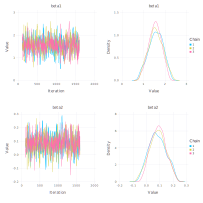

In [12]:
p = Mamba.plot(sim, legend = true)
draw(p, nrow = 2, ncol = 2)

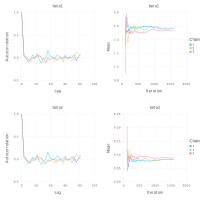

In [13]:
p = Mamba.plot(sim, [:autocor, :mean], legend=true)
draw(p, nrow = 2, ncol = 2)

### Estimate Potential Scale Reduction Factor
Gelman-Rubin diagnostic ($\hat{R}$)

In [14]:
gelmandiag(sim, mpsrf = true, transform = true)

              PSRF 97.5%
       beta1 1.004 1.011
       beta2 1.003 1.009
Multivariate 1.004   NaN



In [15]:
xs = collect(3:0.1:7)

41-element Array{Float64,1}:
 3.0
 3.1
 3.2
 3.3
 3.4
 3.5
 3.6
 3.7
 3.8
 3.9
 4.0
 4.1
 4.2
 ⋮  
 5.9
 6.0
 6.1
 6.2
 6.3
 6.4
 6.5
 6.6
 6.7
 6.8
 6.9
 7.0

In [16]:
sim_beta1 = sim[:, [:beta1], :].value[:]
sim_beta2 = sim[:, [:beta2], :].value[:]
ys = map((x, y) -> exp.(x .+ y .* xs), sim_beta1, sim_beta2)[:];

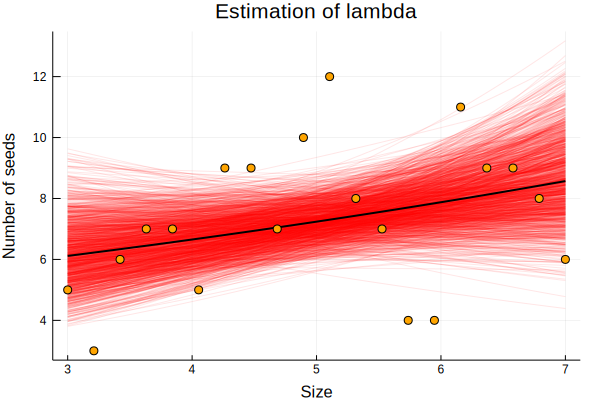

In [17]:
Plots.plot(xs, ys, label = "", linecolor = :red, linealpha = 0.1)
Plots.plot!(xs, exp.(median(sim_beta1) .+ median(sim_beta2) .* xs), label = "", 
            linewidth = 2, linecolor = :black)
scatter!(df.x, df.y, label = "", markercolor = :orange, xlabel = "Size", ylabel = "Number of seeds", 
        title = "Estimation of lambda")

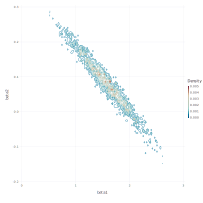

In [18]:
p = Mamba.plot(sim, :contour)
draw(p, nrow = 1, ncol = 1)